線形回帰


使用する特徴ベクトル:
- 曜日
- 当日の売り上げ
- 当日の来客数
- 翌日の観光客予測数
- 食べログの評価
- 1週間の売り上げの平均
- 1週間前の来客数
- イベント情報

目的変数:
- 翌日の来客数

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pylab as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

import math
import sys
%matplotlib inline
sns.set()

In [3]:
sys.path.append('../method/')

In [4]:
import dataset as ds
import preprocessing as pp
import machine_algorithm as ma

In [5]:
data_path = '../csv/wyebiya_data.csv'
df = ds.load_data(data_path)

In [6]:
pd.set_option('display.max_columns', len(df.columns))

In [7]:
df = ds.time_date_sort(df, 'date')

In [8]:
column_name = "shopId"

df_dining = ds.extract_rows(df, column_name, 1)
df_shop = ds.extract_rows(df, column_name, 2)

In [9]:
df_dining_len = len(df_dining)

In [10]:
df_dining.head()

,shopId,dayofweek,salesTotal,CustNum,google,kankou,kankou_tomorrow,kankou_after2days,kankou_after3days,kankou_after4days,kankou_after5days,kankou_after6days,tabelog,tabelog_rating,gurunavi,hitosara,weather_today,rain_precipitation_today,rain_precipitation_today_daytime,temp_today_min,temp_today_max,weather_tomorrow,rain_precipitation_tomorrow,rain_precipitation_tomorrow_daytime,temp_tomorrow_min,temp_tomorrow_max,weather_after2days,rainypercent_after2days,temp_after2days_min,temp_after2days_max,weather_after3days,rainypercent_after3days,temp_after3days_min,temp_after3days_max,weather_after4days,rainypercent_after4days,temp_after4days_min,temp_after4days_max,weather_after5days,rainypercent_after5days,temp_after5days_min,temp_after5days_max,weather_after6days,rainypercent_after6days,temp_after6days_min,temp_after6days_max,google_rating,storeId,kankouReal,kankouReal_tomorrow,kankouReal_after2days,kankouReal_after3days,kankouReal_after4days,kankouReal_after5days,kankouReal_after6days,id
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-01,1,6,789290.0,368.0,82.0,2339.0,NaN,NaN,NaN,NaN,NaN,NaN,871.0,3.54,221.0,84.0,NaN,NaN,NaN,26.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2017-07-02,1,0,1024830.0,462.0,92.0,1392.0,NaN,NaN,NaN,NaN,NaN,NaN,836.0,3.54,288.0,94.0,NaN,NaN,NaN,28.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2017-07-03,1,1,328250.0,154.0,60.0,773.0,NaN,NaN,NaN,NaN,NaN,NaN,508.0,3.54,217.0,68.0,NaN,NaN,NaN,29.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2017-07-04,1,2,320861.0,158.0,71.0,951.0,NaN,NaN,NaN,NaN,NaN,NaN,626.0,3.54,84.0,111.0,NaN,NaN,NaN,27.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2017-07-05,1,3,359703.0,173.0,86.0,970.0,NaN,NaN,NaN,NaN,NaN,NaN,431.0,3.54,88.0,66.0,NaN,NaN,NaN,26.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [11]:
# df_dining['2019-09-01':'2019-09-30']

In [12]:
#  扱う特徴量の選択
# feature = ['dayofweek', 'salesTotal', 'CustNum', 'google', 'kankou', 'tabelog', 'tabelog_rating', 'google_rating']
# feature = ['dayofweek', 'salesTotal', 'CustNum', 'kankou']

# before_feature = ['dayofweek', 'salesTotal', 'CustNum', 'kankou', 'tabelog', 'rain_precipitation_today']
feature = ['dayofweek', 'salesTotal', 'CustNum', 'kankou', 'tabelog']

# before_train_data = df_dining.loc[:,before_feature]
train_data = df_dining.loc[:,feature]

In [13]:
len(train_data)

1006

In [13]:
df_precipitation = df_dining.loc[:, 'rain_precipitation_today']

In [14]:
df_precipitation = df_precipitation.fillna(0)

In [15]:
# df_precipitation

In [16]:
train_data.isnull().sum()

dayofweek      0
salesTotal     5
CustNum        5
kankou         2
tabelog       22
dtype: int64

In [17]:
# 曜日の値が少しずれている部分があるため修正

first_day = train_data['dayofweek'][0]

for date in train_data.index:
    train_data.loc[date, 'dayofweek'] = first_day%7
    first_day += 1

In [18]:
# 前日の値を欠損値に指定
train_data = pp.format_feature(train_data, "tabelog", "before")
# 中央値を欠損値に指定
train_data = pp.format_feature(train_data, "CustNum", "before")
train_data = pp.format_feature(train_data, "salesTotal", "median")
train_data = pp.format_feature(train_data, "kankou", "median")

In [19]:
train_data.isnull().sum()

dayofweek     0
salesTotal    0
CustNum       0
kankou        0
tabelog       0
dtype: int64

### 移動平均を求め，属性ベクトルとして追加する

In [20]:
df_moving_average = train_data.salesTotal

In [21]:
#  売り上げの１週間の移動平均を求める

move_num = 7
df_moving_average = df_moving_average.rolling(window=move_num).mean()

In [22]:
train_data['salesTotal_moving_average'] = df_moving_average

In [23]:
train_data['salesTotal_moving_average']

date
2017-07-01              NaN
2017-07-02              NaN
2017-07-03              NaN
2017-07-04              NaN
2017-07-05              NaN
                  ...      
2020-03-28    596864.571429
2020-03-29    551156.857143
2020-03-30    558101.428571
2020-03-31    518662.285714
2020-04-01    527994.857143
Name: salesTotal_moving_average, Length: 1006, dtype: float64

### 1週間前の来客数を説明変数として用意する

In [24]:
week_ago = train_data['CustNum'].shift(7)

In [25]:
train_data['week_ago'] = week_ago

In [26]:
train_data.head(10)

,dayofweek,salesTotal,CustNum,kankou,tabelog,salesTotal_moving_average,week_ago
date,,,,,,,
2017-07-01,6,789290.0,368.0,2339.0,871.0,NaN,NaN
2017-07-02,0,1024830.0,462.0,1392.0,836.0,NaN,NaN
2017-07-03,1,328250.0,154.0,773.0,508.0,NaN,NaN
2017-07-04,2,320861.0,158.0,951.0,626.0,NaN,NaN
2017-07-05,3,359703.0,173.0,970.0,431.0,NaN,NaN
2017-07-06,4,501675.0,226.0,718.0,673.0,NaN,NaN
2017-07-07,5,401828.0,163.0,1237.0,498.0,532348.142857,NaN
2017-07-08,6,743628.0,334.0,3979.0,932.0,525825.000000,368.0
2017-07-09,0,888732.0,393.0,2146.0,769.0,506382.428571,462.0


### イベント等の影響

In [27]:
df_event_impact = pd.read_csv('../csv/event_impact.csv')

In [28]:
df_event_impact

,date,impact
0,2017-07-01,0.00
1,2017-07-02,0.00
2,2017-07-03,0.00
3,2017-07-04,-3.59
4,2017-07-05,0.00
...,...,...
1001,2020-03-28,-3.59
1002,2020-03-29,-3.59
1003,2020-03-30,0.00
1004,2020-03-31,0.00


In [29]:
# df_event_impact['date'] = df_event_impact['date'].str.replace('/', '-')
# df_event_impact = df_event_impact.replace({'date': {'1': '01','2': '02','3': '03','4': '04','5': '05','6': '06','7': '07','8': '08','9': '09'}})

df_event_impact = df_event_impact.loc[:, ['impact']]
df_event_impact.index = train_data.index

In [30]:
# df_event_correction.to_csv('./correction.csv')

df_event_impact = df_event_impact.loc['2017-07-08':]

In [31]:
df_event_impact

,impact
date,
2017-07-08,0.00
2017-07-09,0.00
2017-07-10,0.00
2017-07-11,0.00
2017-07-12,-3.59
...,...
2020-03-28,-3.59
2020-03-29,-3.59
2020-03-30,0.00


In [32]:
before_train_data = pd.concat([train_data, df_precipitation], axis=1)

In [33]:
before_train_data

,dayofweek,salesTotal,CustNum,kankou,tabelog,salesTotal_moving_average,week_ago,rain_precipitation_today
date,,,,,,,,
2017-07-01,6,789290.0,368.0,2339.0,871.0,NaN,NaN,0.0
2017-07-02,0,1024830.0,462.0,1392.0,836.0,NaN,NaN,0.0
2017-07-03,1,328250.0,154.0,773.0,508.0,NaN,NaN,0.0
2017-07-04,2,320861.0,158.0,951.0,626.0,NaN,NaN,0.0
2017-07-05,3,359703.0,173.0,970.0,431.0,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
2020-03-28,6,560978.0,253.0,6683.0,318.0,596864.571429,555.0,2.0
2020-03-29,0,652850.0,276.0,4156.0,214.0,551156.857143,446.0,2.0
2020-03-30,1,459392.0,206.0,3157.0,230.0,558101.428571,176.0,1.0


In [34]:
# train_data['event_impact'] = df_event_impact

In [35]:
# train_data

In [36]:
train_data = train_data.dropna(how='any')
before_train_data = before_train_data.dropna(how='any')

In [37]:
train_data

,dayofweek,salesTotal,CustNum,kankou,tabelog,salesTotal_moving_average,week_ago
date,,,,,,,
2017-07-08,6,743628.0,334.0,3979.0,932.0,525825.000000,368.0
2017-07-09,0,888732.0,393.0,2146.0,769.0,506382.428571,462.0
2017-07-10,1,441044.0,220.0,1418.0,602.0,522495.857143,154.0
2017-07-11,2,413247.0,196.0,1611.0,780.0,535693.857143,158.0
2017-07-12,3,347005.0,152.0,1646.0,841.0,533879.857143,173.0
...,...,...,...,...,...,...,...
2020-03-28,6,560978.0,253.0,6683.0,318.0,596864.571429,555.0
2020-03-29,0,652850.0,276.0,4156.0,214.0,551156.857143,446.0
2020-03-30,1,459392.0,206.0,3157.0,230.0,558101.428571,176.0


In [38]:
before_train_data

,dayofweek,salesTotal,CustNum,kankou,tabelog,salesTotal_moving_average,week_ago,rain_precipitation_today
date,,,,,,,,
2017-07-08,6,743628.0,334.0,3979.0,932.0,525825.000000,368.0,0.0
2017-07-09,0,888732.0,393.0,2146.0,769.0,506382.428571,462.0,0.0
2017-07-10,1,441044.0,220.0,1418.0,602.0,522495.857143,154.0,0.0
2017-07-11,2,413247.0,196.0,1611.0,780.0,535693.857143,158.0,0.0
2017-07-12,3,347005.0,152.0,1646.0,841.0,533879.857143,173.0,0.0
...,...,...,...,...,...,...,...,...
2020-03-28,6,560978.0,253.0,6683.0,318.0,596864.571429,555.0,2.0
2020-03-29,0,652850.0,276.0,4156.0,214.0,551156.857143,446.0,2.0
2020-03-30,1,459392.0,206.0,3157.0,230.0,558101.428571,176.0,1.0


### 必要な関数の用意

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [41]:
# スケーラーの作成
scaler = MinMaxScaler()
event_scaler = MinMaxScaler([-1, 1])

In [42]:
#　訓練，テストデータ数
train_num = 365
test_num = 30

In [43]:
def before_preparation_data(df, scaler):
    X = np.array(df).reshape(-1, len(df.columns))
    X = X[:-1, :]

    y = df['CustNum'][1:]
    y = np.array(y).reshape(-1, 1) 
    
    # スケーリング
    X = pp.feature_scaling(X, scaler)
    y = pp.feature_scaling(y, scaler) 
    
    return X, y, len(X[0])

In [44]:
def preparation_data(df, df_event, scaler, event_scaler):
    
    # 訓練データに結合し，NaNになっている部分を削除する
    df_event = df_event.shift(-1)
    df['event_impact'] = df_event
    df = df.dropna(how='any')
    
    # 影響度とその他の特徴量を分割し，それぞれでスケーリングを行う
    EP = df['event_impact']
    df = df.drop('event_impact', axis=1)
    
    X = np.array(df).reshape(-1, len(df.columns))
    X = X[:-1, :]
    
    y = df['CustNum'][1:]
    y = np.array(y).reshape(-1, 1)
    
    EP = np.array(EP).reshape(-1, 1) 
    EP = EP[:-1, :]
    
    # スケーリング
    # X = pp.feature_scaling(X, scaler)
    # y = pp.feature_scaling(y, scaler)
    
    # EP = pp.feature_scaling(EP, event_scaler)
    
    # X = np.concatenate([X, EP], 1)
    
    return X, y, len(X[0])

In [45]:
def make_dataset(X, y, i, train_num, shift_num):
    start_train = shift_num * i
    end_train = train_num + (shift_num * i)
    start_test = train_num + (shift_num * i)
    end_test = train_num + test_num + (shift_num * i)

    train_X = X[ start_train : end_train,  :]
    test_X = X[ start_test : end_test, :]

    train_y = y[ start_train : end_train,  :]
    test_y = y[ start_test : end_test, :] 
    
    
    return train_X, test_X, train_y, test_y, start_test, end_test

#### 追加

In [46]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import sts

In [47]:
train_data2 = train_data.iloc[:,1:4]
before_train_data2 = before_train_data.iloc[:,[1,2,3,4,-1]]
train_data2.head()
# before_train_data2.head()


,salesTotal,CustNum,kankou
date,,,
2017-07-08,743628.0,334.0,3979.0
2017-07-09,888732.0,393.0,2146.0
2017-07-10,441044.0,220.0,1418.0
2017-07-11,413247.0,196.0,1611.0
2017-07-12,347005.0,152.0,1646.0


In [48]:
#@title Plotting functions
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast

  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_xlabel('Year')
  ax.set_ylabel('y')
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(10, 3 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  ax.set_xlabel('Year')
  fig.autofmt_xdate()
  fig.tight_layout()

  return fig, axes_dict

In [49]:
def build_llevel_model(observed_time_series):
    """モデルの定義
    """
    # 状態成分
    level = sts.LocalLevel(observed_time_series=observed_time_series)
    # 各状態成分（今回は1つのみ）と観測誤差を加算
    model = sts.Sum([level], observed_time_series=observed_time_series)
    return model


def variational_inference(model, observed_time_series, num_variational_steps):
    """変分推論
    """
    variational_posteriors = sts.build_factored_surrogate_posterior(model)
    optimizer = tf.optimizers.Adam(learning_rate=.1)
    
    # ELBO loss (負のELBO)の最小化
    @tf.function(experimental_compile=True)
    def train():
        elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
            target_log_prob_fn=model.joint_log_prob(
                observed_time_series=observed_time_series),
            surrogate_posterior=variational_posteriors,
            optimizer=optimizer,
            num_steps=num_variational_steps)
        return elbo_loss_curve

    elbo_loss_curve = train()

    # ELBOの推移をプロット
    plt.plot(elbo_loss_curve)
    plt.xlabel('step')
    plt.ylabel('-ELBO')
    
    return variational_posteriors


In [50]:
def build_trend_seasonal_model(x_train,y_train):
    
    # トレンド成分
    #trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    
    # 季節成分（12時点周期）
    seasonal = tfp.sts.Seasonal(
        num_seasons=7, observed_time_series=y_train)
    
    #回帰成分
    regression = sts.LinearRegression(design_matrix=x_train)

    # 各成分を足し合わせる
    model = sts.Sum([seasonal,regression], observed_time_series=y_train)
    return model

### 予測

In [51]:
# 訓練データに結合し，NaNになっている部分を削除する
df_event = df_event_impact.shift(-1)
train_data2['event_impact'] = df_event
train_data2 = train_data2.dropna(how='any')

# 影響度とその他の特徴量を分割し，それぞれでスケーリングを行う
EP = train_data2['event_impact']
train_data = train_data2.drop('event_impact', axis=1)

X = np.array(df).reshape(-1, len(df.columns))
X = X[:-1, :]

y = train_data2['CustNum'][1:]
y = np.array(y).reshape(-1, 1)

EP = np.array(EP).reshape(-1, 1)
EP = EP[:-1, :]


In [61]:
# データ分割
train_y_list = []
train_x_list = []
test_y_list = []
x_first = 0
y_first = 366
for i in range(20):
    train_X = train_data2.iloc[:,[0,2,3]][x_first:y_first-1]
    train_y = train_data2["CustNum"][x_first:y_first-1]
    test_y = train_data2["CustNum"][y_first:y_first+30]
    train_x_list.append(train_X)
    train_y_list.append(train_y)
    test_y_list.append(test_y)
    x_first += 30
    y_first += 30

In [67]:
train3 = []
test3 = []
x_first = 0
y_first = 366
for i in range(20):
    train_X = train_data2[x_first:y_first-1]
    # test_y = train_data2["CustNum"][y_first:y_first+30]
    test_y = train_data2[y_first:y_first+30]
    train3.append(train_X)
    test3.append(test_y)
    x_first += 30
    y_first += 30

In [70]:
test3[7]

,salesTotal,CustNum,kankou,event_impact
date,,,,
2019-02-04,651920.0,252.0,1850.0,0.00
2019-02-05,412760.0,171.0,1255.0,-3.59
2019-02-06,316000.0,116.0,1515.0,0.00
2019-02-07,524690.0,203.0,1169.0,0.00
2019-02-08,575860.0,159.0,1678.0,12.22
2019-02-09,1030370.0,420.0,6671.0,12.22
2019-02-10,1457930.0,563.0,8060.0,12.22
2019-02-11,1157910.0,453.0,4021.0,0.00
2019-02-12,496260.0,207.0,1620.0,0.00


In [78]:
train3[7]

,salesTotal,CustNum,kankou,event_impact
date,,,,
2018-02-03,1163802.0,434.0,4869.0,0.00
2018-02-04,1096200.0,430.0,2616.0,0.00
2018-02-05,646822.0,280.0,1643.0,0.00
2018-02-06,548412.0,255.0,837.0,0.00
2018-02-07,492354.0,217.0,1219.0,0.00
...,...,...,...,...
2019-01-29,776750.0,283.0,1019.0,0.00
2019-01-30,535450.0,230.0,387.0,-3.59
2019-01-31,287150.0,105.0,394.0,0.00


In [72]:
len(train3[7])

365

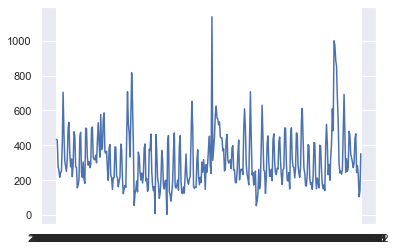

In [76]:
plt.plot(train3[7]["CustNum"])

In [60]:
train3[7].to_csv('train.csv')

In [71]:
test3[7].to_csv('test.csv')

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2022-08-16 00:58:25.190739: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/StatefulPartitionedCall/monte_carlo_variational_loss/default_joint_bijectorJointDistributionNamedAutoBatched_CONSTRUCTED_AT_monte_carlo_variational_loss_build_factored_surrogate_posterior_1/sample_and_log_prob/JointDistributionNamedAutoBatched/sample_and_log_prob/sanitize_seed/seed


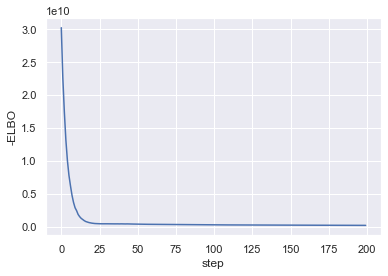

In [54]:
#@title 変分推論
#%%time
trend_seasonal_model = build_trend_seasonal_model(train_x_list[7],train_y_list[7])

num_variational_steps = 200
variational_posteriors = variational_inference(trend_seasonal_model, 
                                               train_x_list[7], 
                                               num_variational_steps)

# # 近似事後分布からのサンプルを取得
q_samples = variational_posteriors.sample(50)


In [54]:
num_forecast_steps = 30

In [69]:
#@title Plot forecast
# パラメータの事後分布からのサンプルを用いて、未来の観測値の予測分布を算出する。
# tfd.MixtureSameFamilyが返される。混合要素数は事後分布からのサンプル数となる。
pred_dist = tfp.sts.forecast(
    model=trend_seasonal_model,
    observed_time_series=train_x_list[7],
    parameter_samples=q_samples,
    num_steps_forecast=num_forecast_steps)



ValueError: Incompatible shapes for broadcasting. Two shapes are compatible if for each dimension pair they are either equal or one of them is 1. Received: (4,) and (50,).

In [ ]:
import matplotlib.dates as mdates

dates = np.arange("2017-07-10", "2020-04-02", dtype="datetime64[D]")
x_loc = mdates.YearLocator(5)
x_fmt = mdates.DateFormatter('%M')


In [ ]:
# 予測分布の平均、標準偏差を算出、予測分布からのサンプルも取得
num_samples=10
(
    pred_mean,
    pred_scale,
    pred_samples
) = (
    pred_dist.mean().numpy()[..., 0],
    pred_dist.stddev().numpy()[..., 0],
    pred_dist.sample(num_samples).numpy()[..., 0]
    )

plot_forecast(dates[-num_forecast_steps:],df_dining["CustNum"] , pred_mean, pred_scale, pred_samples, x_loc, x_fmt)

### イベント影響度を考慮する前の予測

In [ ]:
X, y, column_num = before_preparation_data(before_train_data, scaler)

train_y_list = []
test_y_list = []
predict_list = []
compare_list = []
error_rate_list = []
date_list = []

# 各期間の評価を格納
r2_list = []
mse_list = []
rmse_list = []

df_compare = pd.DataFrame()
df_sub = pd.DataFrame()

# svm_model = make_svm_model()
lin_reg_model = LinearRegression()
# ridge_model = Ridge()
# lasso_001_model = Lasso(alpha=0.01,max_iter=1000)
# model = 

# 予測する数
shift_num = 30 # <- ズラしたい期間
pred_num = int((len(X) - train_num - test_num) / shift_num) 

# 学習，　予測
for i in range(pred_num + 1):

    # 1年間を訓練データとし，　1ヶ月をテストデータとする。　それを1ヶ月ずつずらして予測を行う。
    train_X, test_X, train_y, test_y, start_test, end_test = make_dataset(X, y, i, train_num, shift_num)
    date_list.append(train_data.index[start_test])

    # 回帰に渡せる形にする 
    train_X = train_X.reshape(-1, column_num)
    test_X = test_X.reshape(-1, column_num) 

    #　学習
#     svm_model.fit(train_X, train_y)
    lin_reg_model.fit(train_X, train_y)
#     ridge_model.fit(train_X, train_y)
#     lasso_001_model.fit(train_X, train_y)

    # 予測 
    predict = lin_reg_model.predict(test_X)
#     predict = ridge_model.predict(test_X)
#     predict = lasso_001_model.predict(test_X)
    
    predict = predict.reshape(-1, 1)

    # オリジナルのスケールに戻す
    test_y = pp.restore_scaling(test_y, scaler)
    predict = pp.restore_scaling(predict, scaler)

    #  answer と　predict　を同じDataFrameに (ラベルデータ，　予測したデータ，　元のデータセット)
    # +1しているのは，　1週間前のデータを使用するため，　2017/07/07のデータもNaNになったため 
    test_y.index = df_dining[start_test+move_num+1:end_test+move_num+1].index
    predict.index = df_dining[start_test+move_num+1:end_test+move_num+1].index

    compare = pd.concat([test_y, predict], axis=1)
    compare.columns = ["Answer", "Predict"]

    test_y_list.append(test_y)
    predict_list.append(predict)

    compare_list.append(compare)

    df_compare = pd.concat([df_compare, compare])


    # 特徴ベクトル
    feature_vector = train_data.shift()

    # 平均二乗平方根誤差
    mse = mean_squared_error(test_y, predict)
    rmse = np.sqrt(mse)

    r2_list.append(r2_score(test_y, predict))
    mse_list.append(mse)
    rmse_list.append(rmse)

#     model_loss_plot(history)

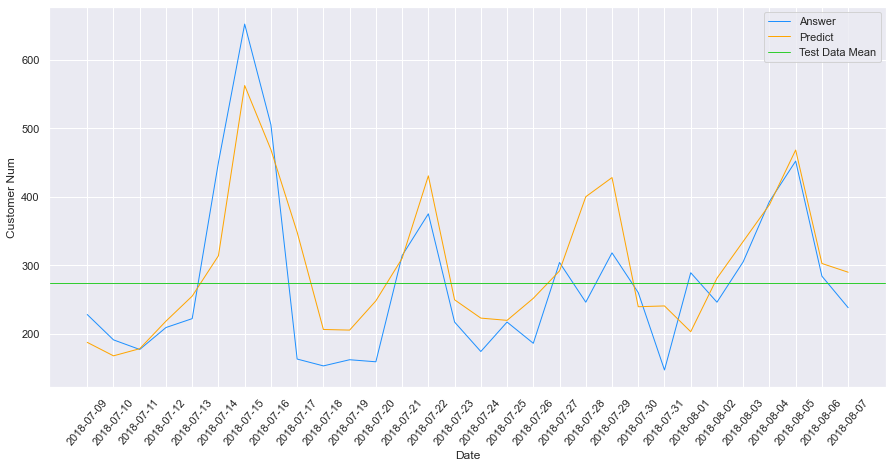

---------------------------------------------------------------------------------------
決定係数：0.6419567001968907
-
MSE(平均二乗誤差)　:  4899.052366885085
-
RMSE(平均二乗平方根誤差)　:  69.99323086474209
---------------------------------------------------------------------------------------


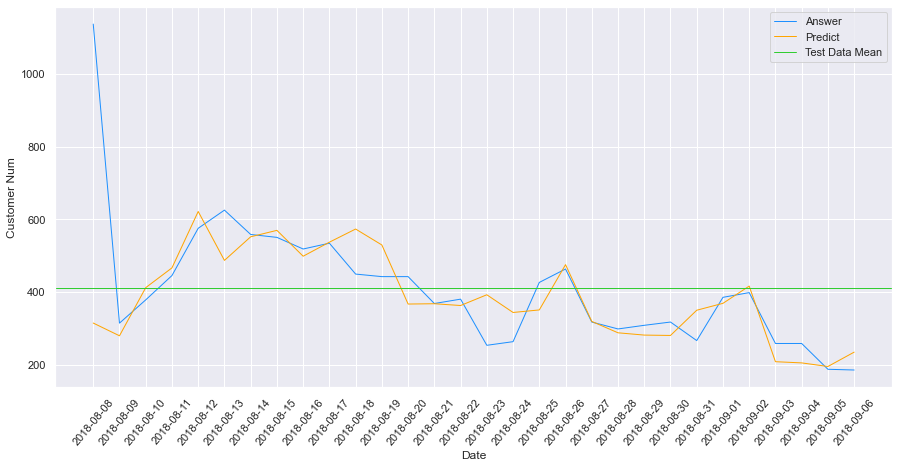

---------------------------------------------------------------------------------------
決定係数：0.17523403266430337
-
MSE(平均二乗誤差)　:  26003.68053788166
-
RMSE(平均二乗平方根誤差)　:  161.2565674255832
---------------------------------------------------------------------------------------


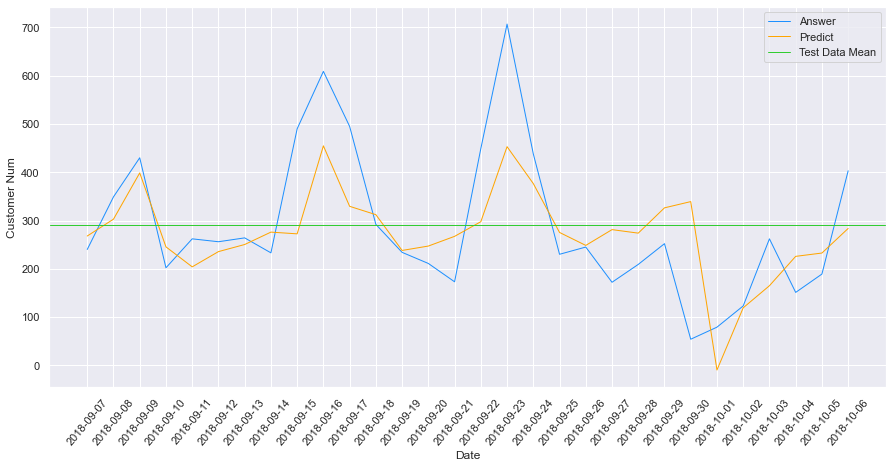

---------------------------------------------------------------------------------------
決定係数：0.4652151719817992
-
MSE(平均二乗誤差)　:  11869.633040820358
-
RMSE(平均二乗平方根誤差)　:  108.94784550793264
---------------------------------------------------------------------------------------


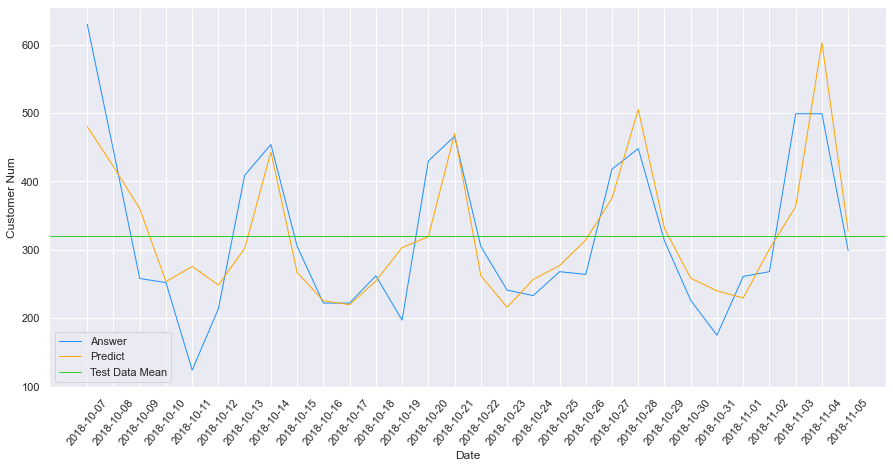

---------------------------------------------------------------------------------------
決定係数：0.6547046364713736
-
MSE(平均二乗誤差)　:  4759.820237600625
-
RMSE(平均二乗平方根誤差)　:  68.99145046743564
---------------------------------------------------------------------------------------


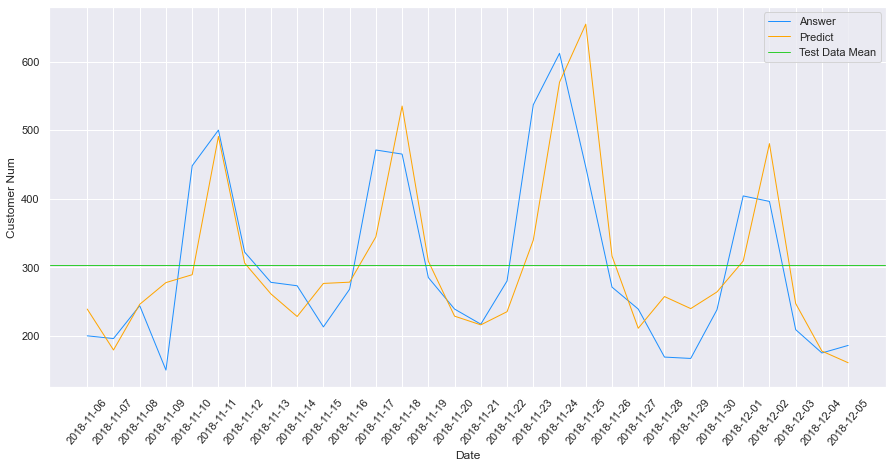

---------------------------------------------------------------------------------------
決定係数：0.5819477597878866
-
MSE(平均二乗誤差)　:  6424.708580017846
-
RMSE(平均二乗平方根誤差)　:  80.15427986088982
---------------------------------------------------------------------------------------


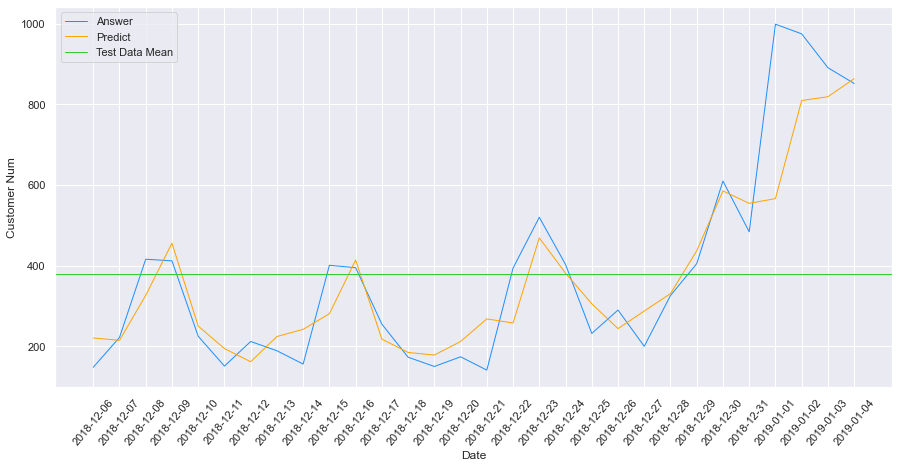

---------------------------------------------------------------------------------------
決定係数：0.8237434732531331
-
MSE(平均二乗誤差)　:  10899.286277739031
-
RMSE(平均二乗平方根誤差)　:  104.39964692344046
---------------------------------------------------------------------------------------


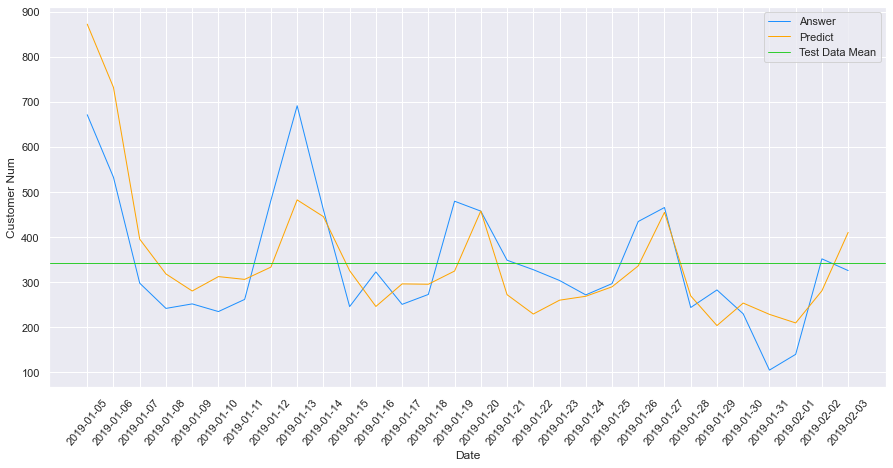

---------------------------------------------------------------------------------------
決定係数：0.4973580301691566
-
MSE(平均二乗誤差)　:  9218.637470262194
-
RMSE(平均二乗平方根誤差)　:  96.0137358416086
---------------------------------------------------------------------------------------


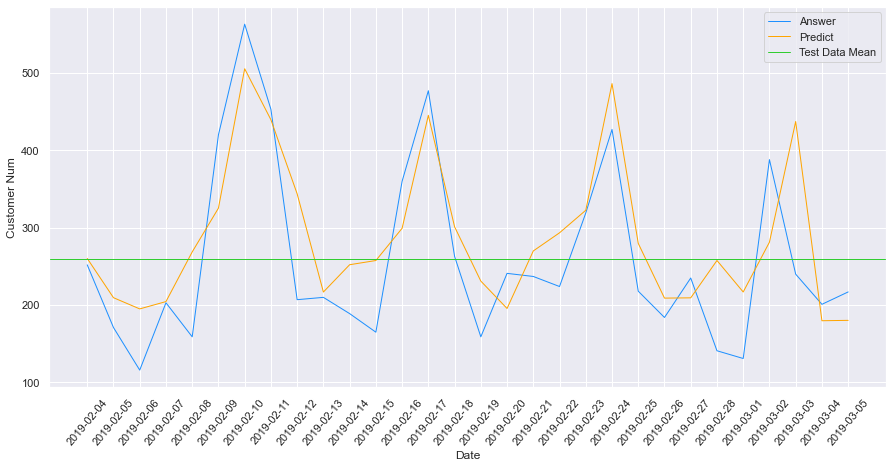

---------------------------------------------------------------------------------------
決定係数：0.5645623560908578
-
MSE(平均二乗誤差)　:  5488.110917949525
-
RMSE(平均二乗平方根誤差)　:  74.08178533181773
---------------------------------------------------------------------------------------


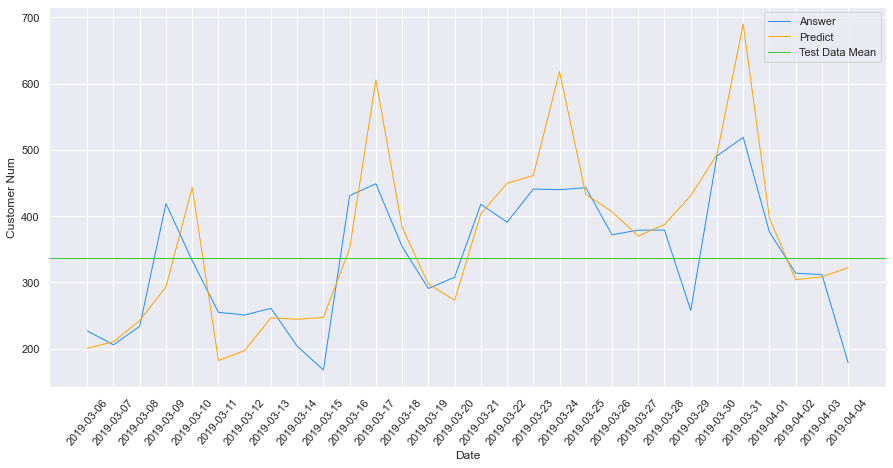

---------------------------------------------------------------------------------------
決定係数：0.2889109269066822
-
MSE(平均二乗誤差)　:  6518.111867722157
-
RMSE(平均二乗平方根誤差)　:  80.73482438032647
---------------------------------------------------------------------------------------


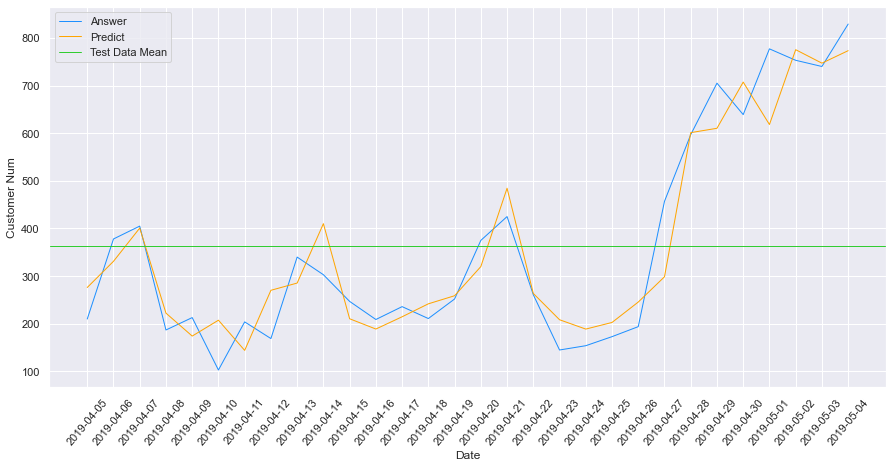

---------------------------------------------------------------------------------------
決定係数：0.9045863383389595
-
MSE(平均二乗誤差)　:  4490.856970572732
-
RMSE(平均二乗平方根誤差)　:  67.0138565564819
---------------------------------------------------------------------------------------


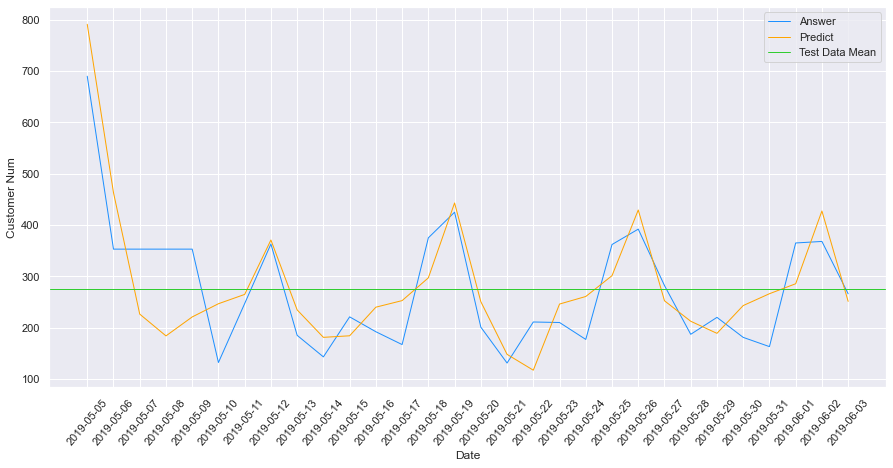

---------------------------------------------------------------------------------------
決定係数：0.5916860940697268
-
MSE(平均二乗誤差)　:  5708.816376929758
-
RMSE(平均二乗平方根誤差)　:  75.55670967511594
---------------------------------------------------------------------------------------


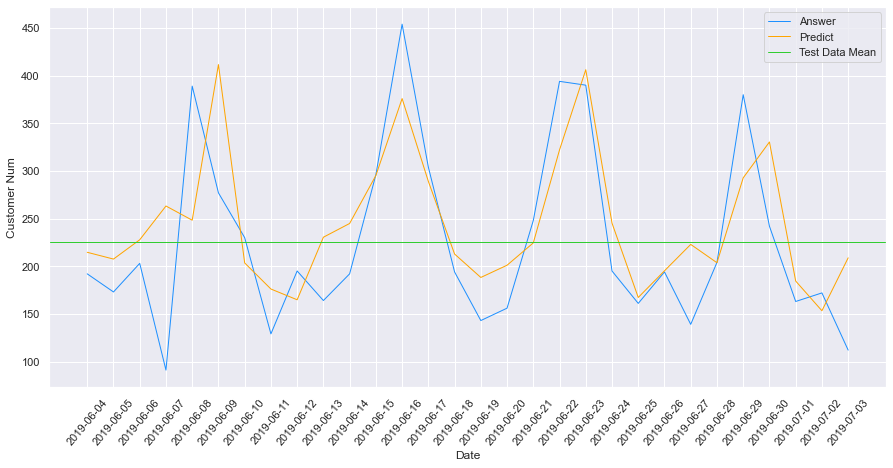

---------------------------------------------------------------------------------------
決定係数：0.4825747436668689
-
MSE(平均二乗誤差)　:  4428.737055335312
-
RMSE(平均二乗平方根誤差)　:  66.54875697813831
---------------------------------------------------------------------------------------


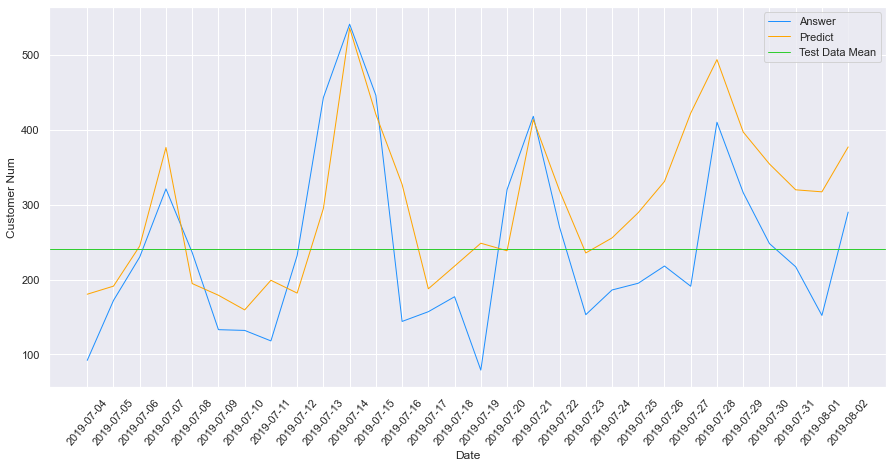

---------------------------------------------------------------------------------------
決定係数：0.2881929042753163
-
MSE(平均二乗誤差)　:  9285.603444302573
-
RMSE(平均二乗平方根誤差)　:  96.36183603638202
---------------------------------------------------------------------------------------


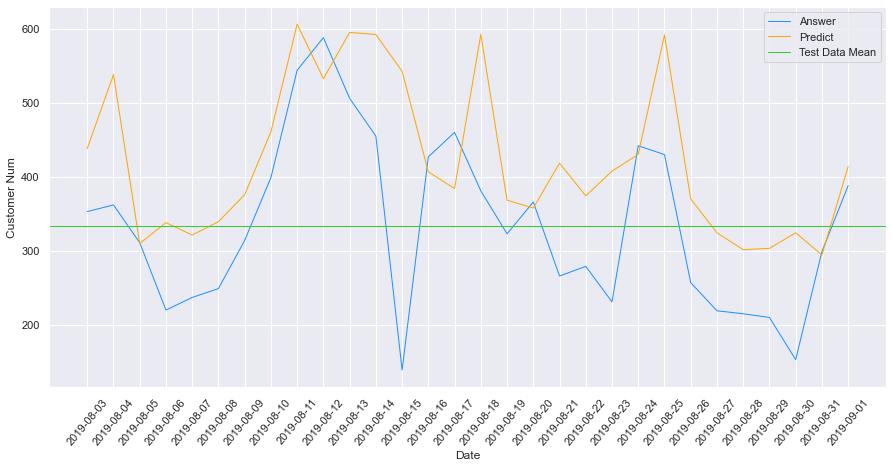

---------------------------------------------------------------------------------------
決定係数：-0.2777328533273893
-
MSE(平均二乗誤差)　:  16159.261663227404
-
RMSE(平均二乗平方根誤差)　:  127.11908457516284
---------------------------------------------------------------------------------------


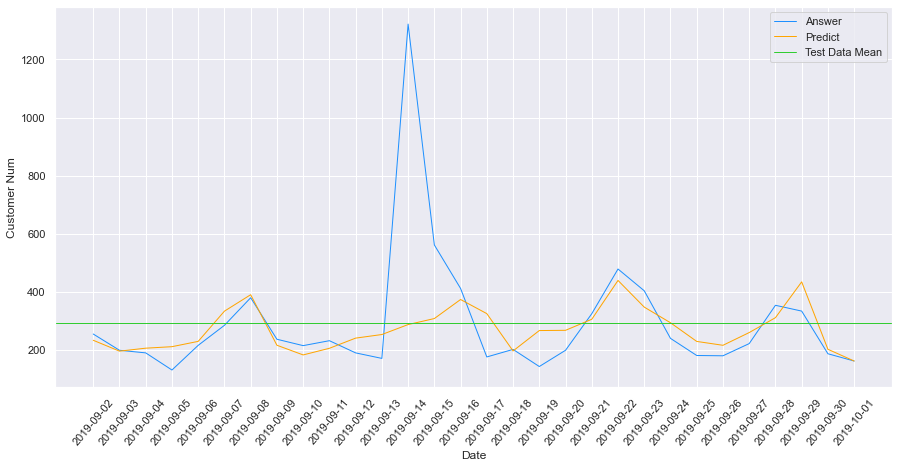

---------------------------------------------------------------------------------------
決定係数：0.13277003002372667
-
MSE(平均二乗誤差)　:  40897.39366003273
-
RMSE(平均二乗平方根誤差)　:  202.231040298053
---------------------------------------------------------------------------------------


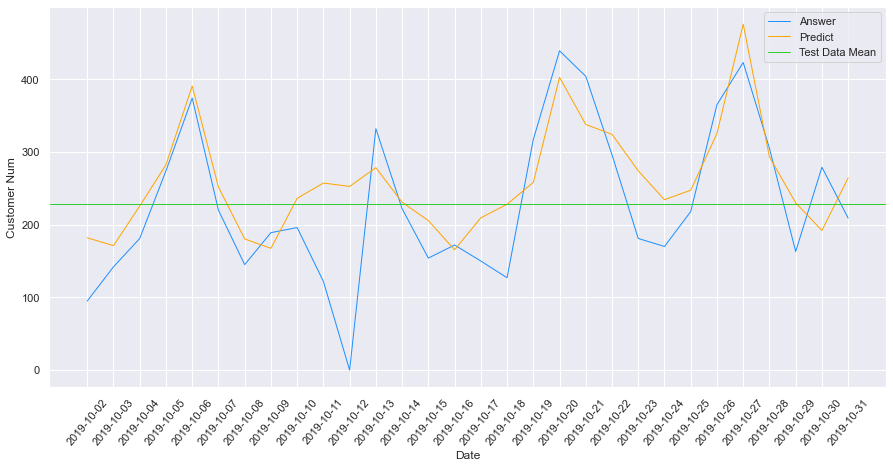

---------------------------------------------------------------------------------------
決定係数：0.5050088750185617
-
MSE(平均二乗誤差)　:  5326.084705155276
-
RMSE(平均二乗平方根誤差)　:  72.9800294954399
---------------------------------------------------------------------------------------


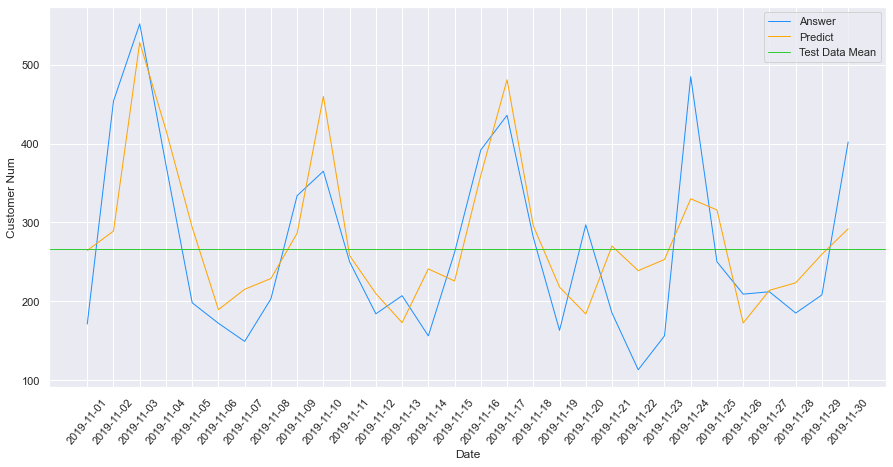

---------------------------------------------------------------------------------------
決定係数：0.5552401687863313
-
MSE(平均二乗誤差)　:  5739.756084696218
-
RMSE(平均二乗平方根誤差)　:  75.7611779521426
---------------------------------------------------------------------------------------


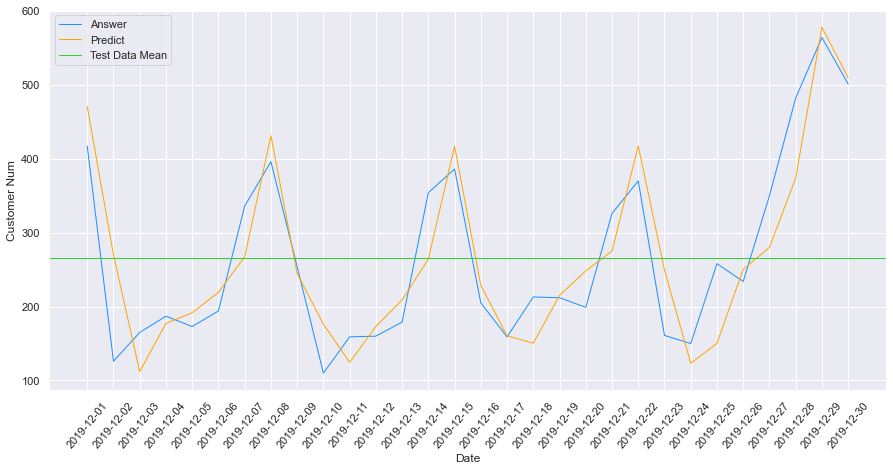

---------------------------------------------------------------------------------------
決定係数：0.7739729485505726
-
MSE(平均二乗誤差)　:  3273.3538960308006
-
RMSE(平均二乗平方根誤差)　:  57.21323182648224
---------------------------------------------------------------------------------------


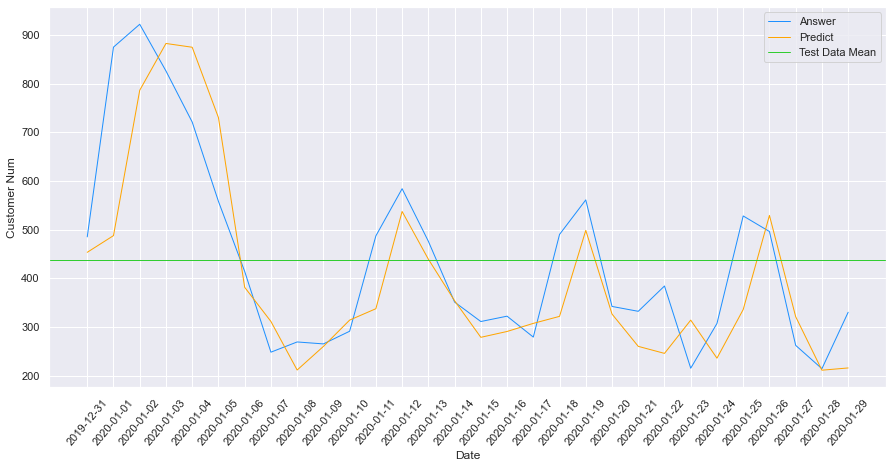

---------------------------------------------------------------------------------------
決定係数：0.6417696608370855
-
MSE(平均二乗誤差)　:  13006.247032133875
-
RMSE(平均二乗平方根誤差)　:  114.04493426774323
---------------------------------------------------------------------------------------


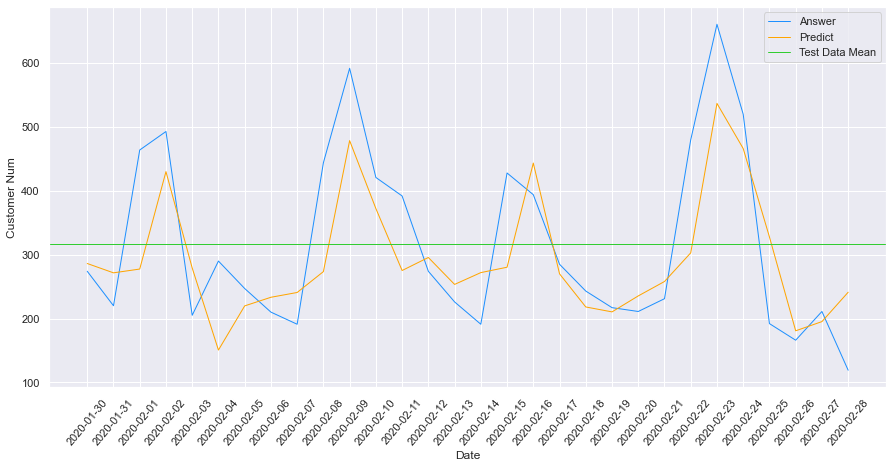

---------------------------------------------------------------------------------------
決定係数：0.5700905978837832
-
MSE(平均二乗誤差)　:  8195.408789544334
-
RMSE(平均二乗平方根誤差)　:  90.5284971130325
---------------------------------------------------------------------------------------


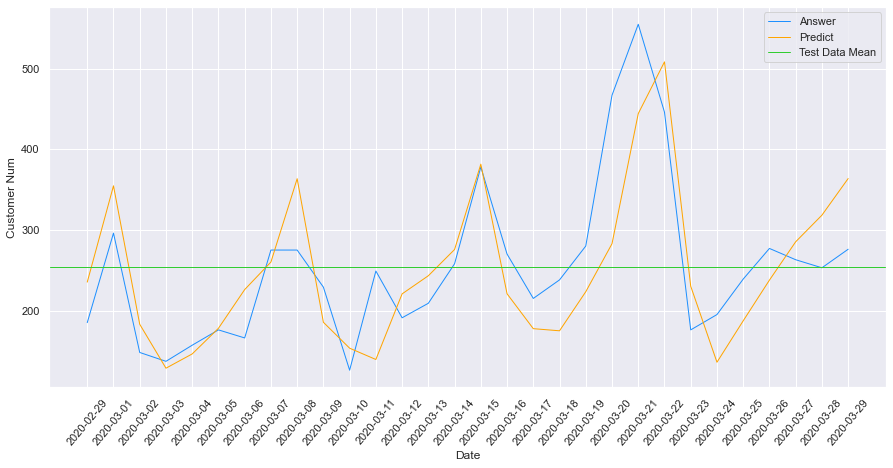

---------------------------------------------------------------------------------------
決定係数：0.5711137559765438
-
MSE(平均二乗誤差)　:  4008.792574783178
-
RMSE(平均二乗平方根誤差)　:  63.31502645330868
---------------------------------------------------------------------------------------


In [ ]:
for i in range(len(predict_list)):
# for i in range(2):
    
    plt.figure(figsize=(15, 7))
    plt.plot(test_y_list[i], color='dodgerblue', linewidth=1, label="Answer")
    plt.plot(predict_list[i], color='orange', linewidth=1, label="Predict")
    plt.axhline(y=float(test_y_list[i].mean()), color='limegreen', linewidth=1, label="Test Data Mean")
#     plt.plot(float(test_y_list[i].mean()), color='lime', linewidth=1, label="Test Data Mean")
    plt.legend(loc = 'best')
    plt.xticks(rotation=50)
    plt.xlabel("Date")
    plt.ylabel("Customer Num")
    plt.show()
    plt.close()
    
    print("---------------------------------------------------------------------------------------")
    print("決定係数：{}".format(r2_list[i]))
    print("-")
    print("MSE(平均二乗誤差)　:  {}".format(mse_list[i]))
    print("-")
    print("RMSE(平均二乗平方根誤差)　:  {}".format(rmse_list[i]))
    print("---------------------------------------------------------------------------------------")
    

#### 結果を保存

In [ ]:
import pickle

# 予測結果
# f = open('./output/before/predict_list.txt', 'wb')
# pickle.dump(predict_list, f)

# 二乗平均平方根誤差
rmse_plot = pd.DataFrame(rmse_list)
rmse_plot.index = date_list
rmse_plot.columns = ['RMSE'] 
# rmse_plot.to_pickle('./output/before/rmse_list.pkl')

# 決定係数
r2_plot = pd.DataFrame(r2_list)
r2_plot.index = date_list
r2_plot.columns = ['R^2']
# r2_plot.to_pickle('./output/before/r2_list.pkl')


### イベント影響度を考慮した予測

In [ ]:
X, y, column_num = preparation_data(train_data, df_event_impact, scaler, event_scaler)

train_y_list = []
test_y_list = []
predict_list = []
compare_list = []
error_rate_list = []
date_list = []

# 各期間の評価を格納
r2_list = []
mse_list = []
rmse_list = []

df_compare = pd.DataFrame()
df_sub = pd.DataFrame()

# svm_model = make_svm_model()
lin_reg_model = LinearRegression()
# ridge_model = Ridge()
# lasso_001_model = Lasso(alpha=0.01,max_iter=1000)

# 予測する数
shift_num = 30 # <- ズラしたい期間
pred_num = int((len(X) - train_num - test_num) / shift_num) 

# 学習，　予測
for i in range(pred_num + 1):

    # 1年間を訓練データとし，　1ヶ月をテストデータとする。　それを1ヶ月ずつずらして予測を行う。
    train_X, test_X, train_y, test_y, start_test, end_test = make_dataset(X, y, i, train_num, shift_num)
    date_list.append(train_data.index[start_test+1])

    # 回帰に渡せる形にする 
    train_X = train_X.reshape(-1, column_num)
    test_X = test_X.reshape(-1, column_num) 

    #　学習
#     svm_model.fit(train_X, train_y)
    lin_reg_model.fit(train_X, train_y)
#     ridge_model.fit(train_X, train_y)
#     lasso_001_model.fit(train_X, train_y)
    
    # 予測 
    predict = lin_reg_model.predict(test_X)
#     predict = ridge_model.predict(test_X)
#     predict = lasso_001_model.predict(test_X)
    
    predict = predict.reshape(-1, 1)

    # オリジナルのスケールに戻す
    test_y = pp.restore_scaling(test_y, scaler)
    predict = pp.restore_scaling(predict, scaler)

    #  answer と　predict　を同じDataFrameに (ラベルデータ，　予測したデータ，　元のデータセット)
    # +1しているのは，　1週間前のデータを使用するため，　2017/07/07のデータもNaNになったため 
    test_y.index = df_dining[start_test+move_num+1:end_test+move_num+1].index
    predict.index = df_dining[start_test+move_num+1:end_test+move_num+1].index

    compare = pd.concat([test_y, predict], axis=1)
    compare.columns = ["Answer", "Predict"]

    test_y_list.append(test_y)
    predict_list.append(predict)

    compare_list.append(compare)

    df_compare = pd.concat([df_compare, compare])


    # 特徴ベクトル
    feature_vector = train_data.shift()

    # 平均二乗平方根誤差
    mse = mean_squared_error(test_y, predict)
    rmse = np.sqrt(mse)

    r2_list.append(r2_score(test_y, predict))
    mse_list.append(mse)
    rmse_list.append(rmse)

#     model_loss_plot(history)

/var/folders/tv/xbz88bwn3bv07cd4ktfz_dcc0000gn/T/ipykernel_63047/4029431846.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['event_impact'] = df_event


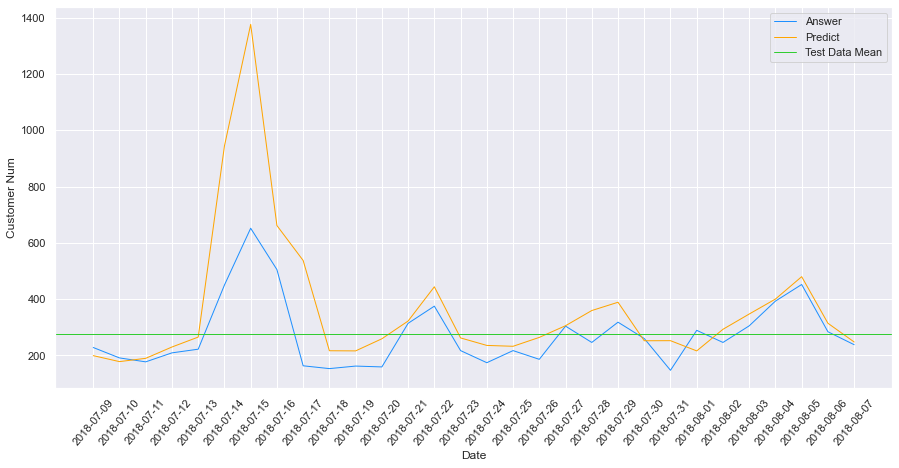

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(test_y_list[0], color='dodgerblue', linewidth=1, label="Answer")
plt.plot(predict_list[0], color='orange', linewidth=1, label="Predict")
plt.axhline(y=float(test_y_list[0].mean()), color='limegreen', linewidth=1, label="Test Data Mean")
plt.legend(loc='best')
plt.xticks(rotation=50)
plt.xlabel("Date")
plt.ylabel("Customer Num")
plt.show()
plt.close()


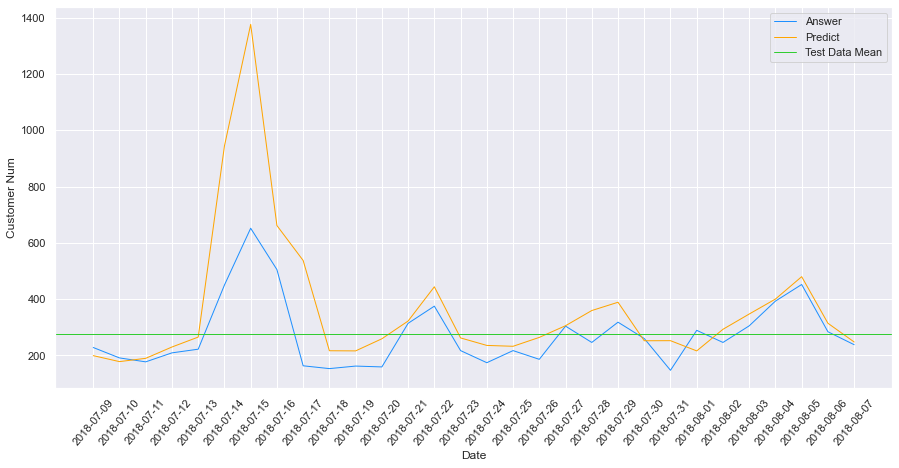

---------------------------------------------------------------------------------------
決定係数：-1.4643413414772462
-
MSE(平均二乗誤差)　:  33719.21018607489
-
RMSE(平均二乗平方根誤差)　:  183.62791232836824
---------------------------------------------------------------------------------------


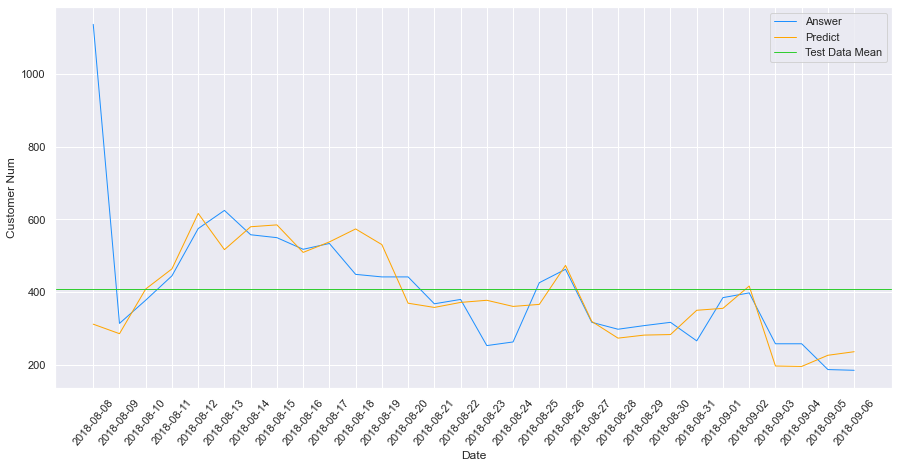

---------------------------------------------------------------------------------------
決定係数：0.17707829369924877
-
MSE(平均二乗誤差)　:  25945.533649333254
-
RMSE(平均二乗平方根誤差)　:  161.07617343770386
---------------------------------------------------------------------------------------


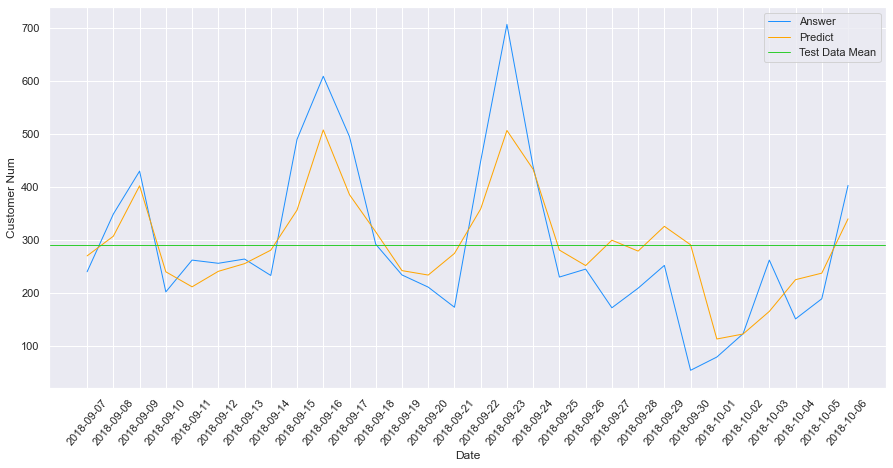

---------------------------------------------------------------------------------------
決定係数：0.6732153108150181
-
MSE(平均二乗誤差)　:  7253.037372728648
-
RMSE(平均二乗平方根誤差)　:  85.1647660287319
---------------------------------------------------------------------------------------


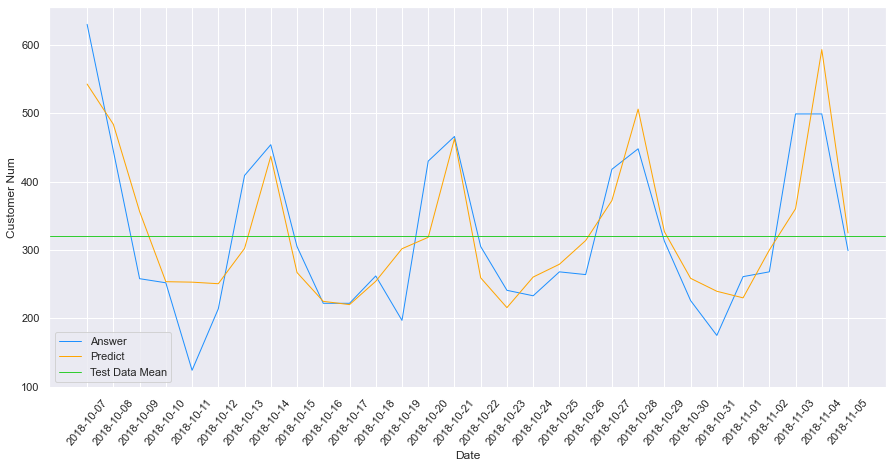

---------------------------------------------------------------------------------------
決定係数：0.7071879748221309
-
MSE(平均二乗誤差)　:  4036.3490230846915
-
RMSE(平均二乗平方根誤差)　:  63.53226757392413
---------------------------------------------------------------------------------------


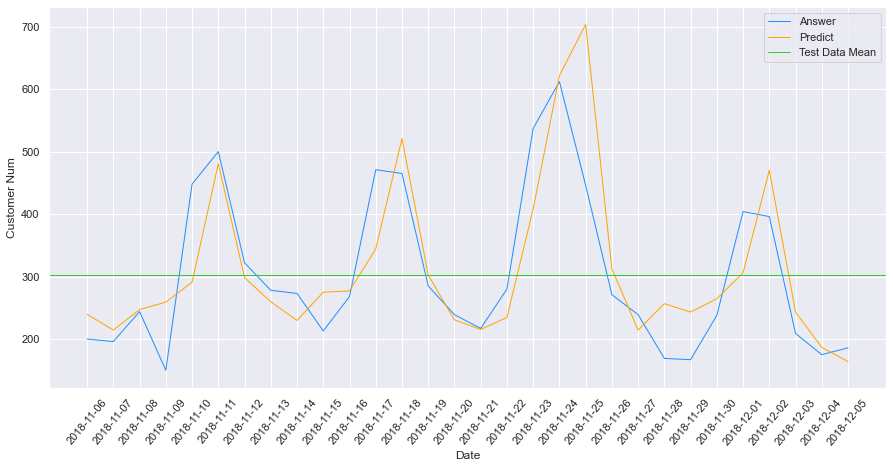

---------------------------------------------------------------------------------------
決定係数：0.6017376168259503
-
MSE(平均二乗誤差)　:  6120.574187040393
-
RMSE(平均二乗平方根誤差)　:  78.23409862100024
---------------------------------------------------------------------------------------


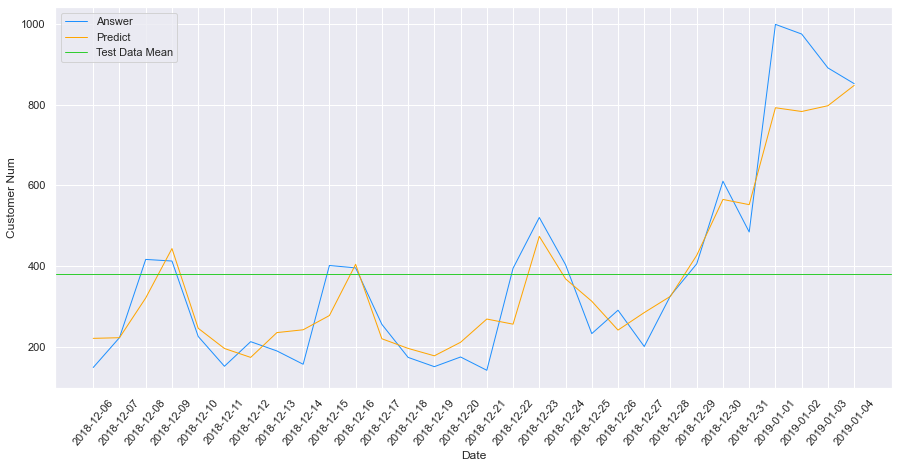

---------------------------------------------------------------------------------------
決定係数：0.8931373143802246
-
MSE(平均二乗誤差)　:  6608.135451634626
-
RMSE(平均二乗平方根誤差)　:  81.2904388697381
---------------------------------------------------------------------------------------


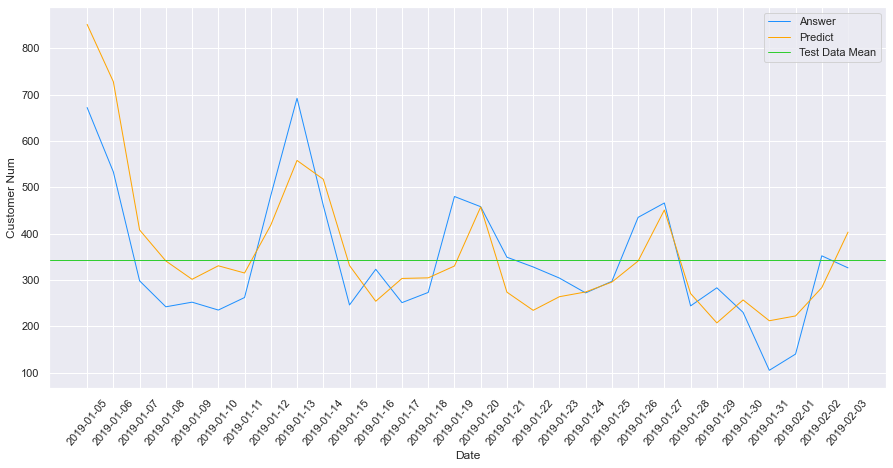

---------------------------------------------------------------------------------------
決定係数：0.5803004537085299
-
MSE(平均二乗誤差)　:  7697.4431024863725
-
RMSE(平均二乗平方根誤差)　:  87.73507338850509
---------------------------------------------------------------------------------------


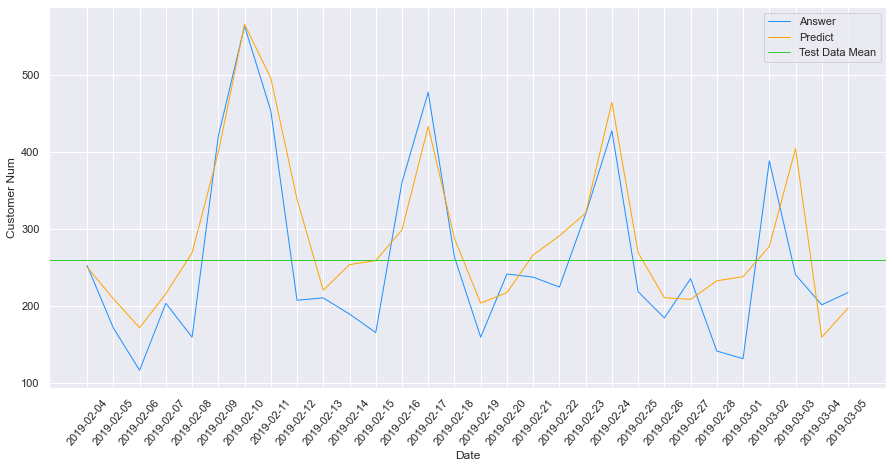

---------------------------------------------------------------------------------------
決定係数：0.6569708577114707
-
MSE(平均二乗誤差)　:  4323.4249663571945
-
RMSE(平均二乗平方根誤差)　:  65.75275634037857
---------------------------------------------------------------------------------------


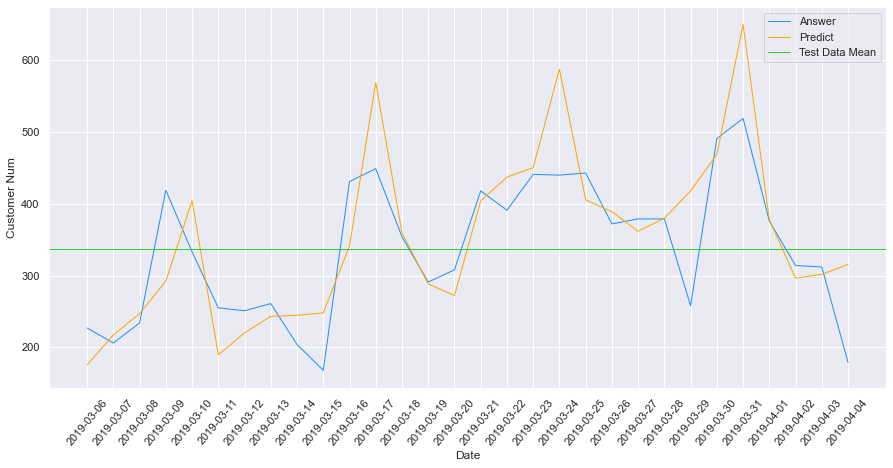

---------------------------------------------------------------------------------------
決定係数：0.4538458002547423
-
MSE(平均二乗誤差)　:  5006.256326622936
-
RMSE(平均二乗平方根誤差)　:  70.7549031984564
---------------------------------------------------------------------------------------


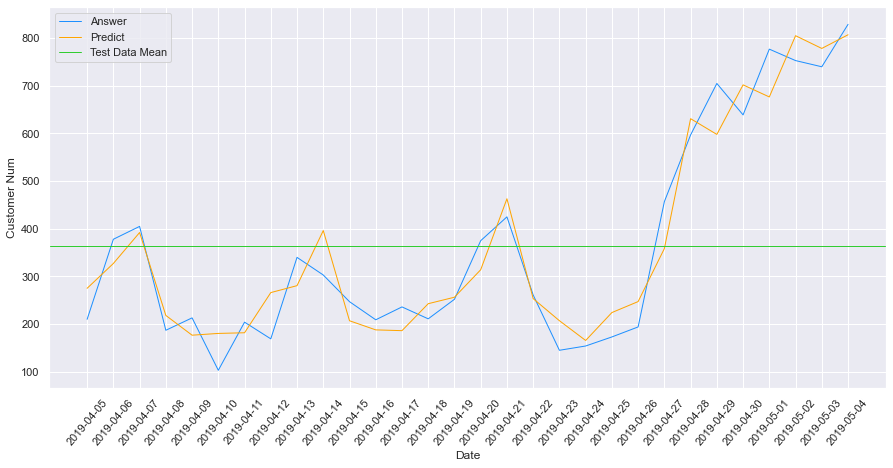

---------------------------------------------------------------------------------------
決定係数：0.9301222279571715
-
MSE(平均二乗誤差)　:  3288.953323911316
-
RMSE(平均二乗平方根誤差)　:  57.349396892306686
---------------------------------------------------------------------------------------


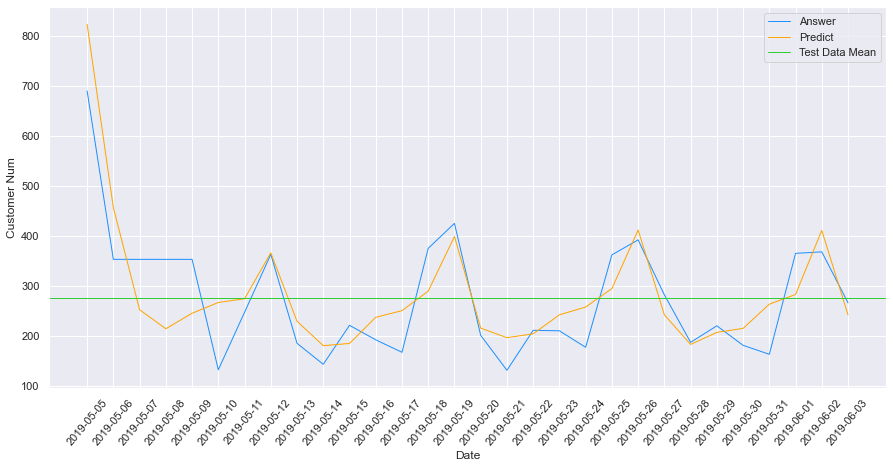

---------------------------------------------------------------------------------------
決定係数：0.6441407203624556
-
MSE(平均二乗誤差)　:  4975.42516669555
-
RMSE(平均二乗平方根誤差)　:  70.53669376073385
---------------------------------------------------------------------------------------


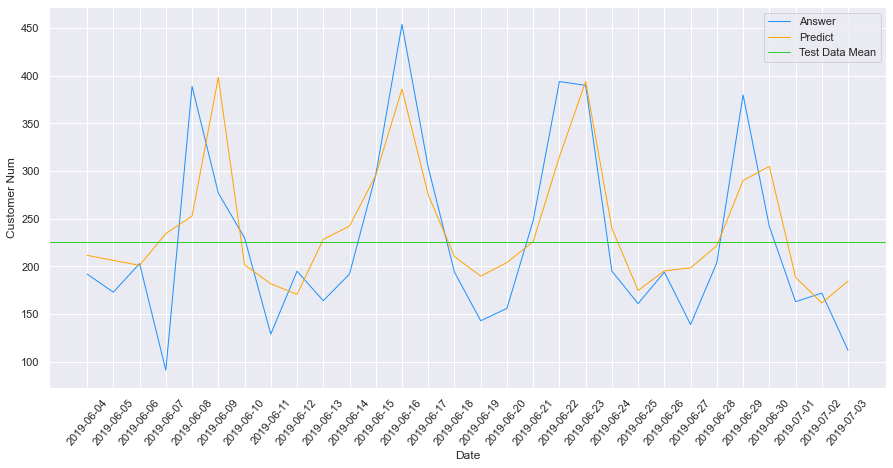

---------------------------------------------------------------------------------------
決定係数：0.5821675871276503
-
MSE(平均二乗誤差)　:  3576.3037601252313
-
RMSE(平均二乗平方根誤差)　:  59.802205311553784
---------------------------------------------------------------------------------------


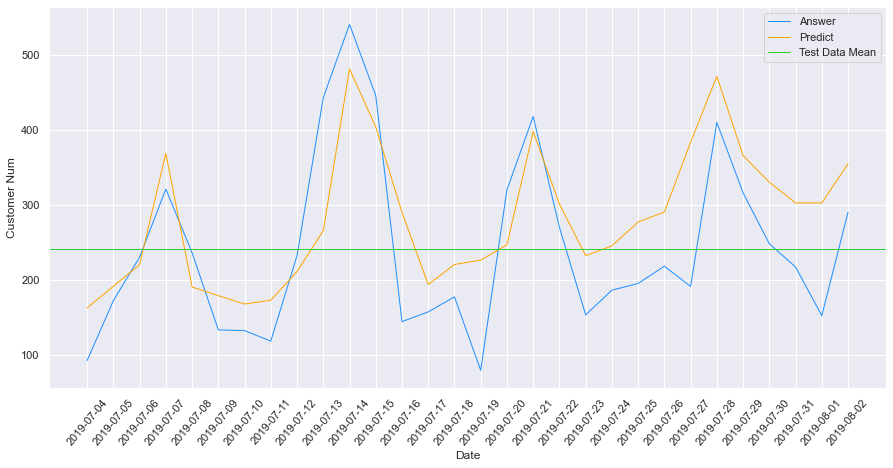

---------------------------------------------------------------------------------------
決定係数：0.4575196595306653
-
MSE(平均二乗誤差)　:  7076.7169197717885
-
RMSE(平均二乗平方根誤差)　:  84.12322461586805
---------------------------------------------------------------------------------------


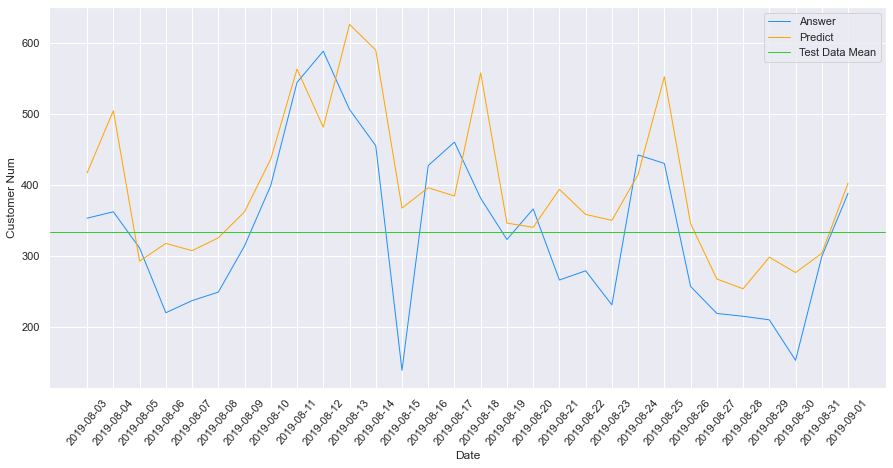

---------------------------------------------------------------------------------------
決定係数：0.28513150547574273
-
MSE(平均二乗誤差)　:  9040.81555681425
-
RMSE(平均二乗平方根誤差)　:  95.08320333694196
---------------------------------------------------------------------------------------


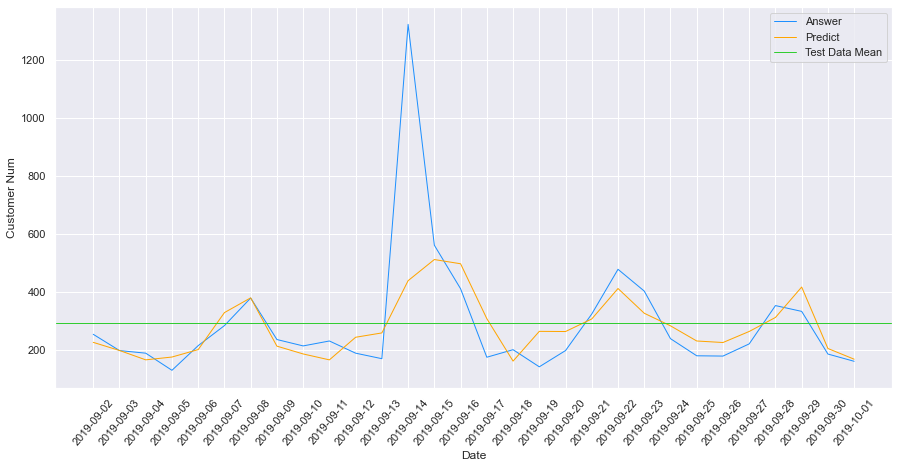

---------------------------------------------------------------------------------------
決定係数：0.37901060532339814
-
MSE(平均二乗誤差)　:  29285.020827277513
-
RMSE(平均二乗平方根誤差)　:  171.12866746187652
---------------------------------------------------------------------------------------


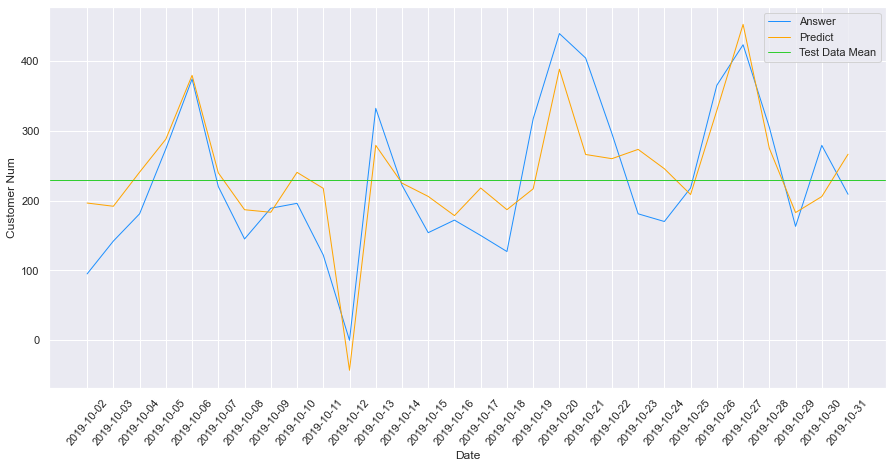

---------------------------------------------------------------------------------------
決定係数：0.6752819191306313
-
MSE(平均二乗誤差)　:  3493.9535614311726
-
RMSE(平均二乗平方根誤差)　:  59.109674008838624
---------------------------------------------------------------------------------------


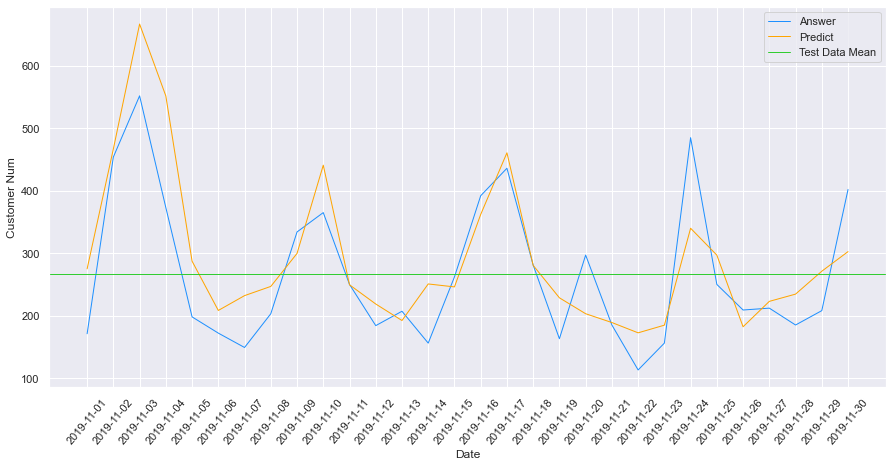

---------------------------------------------------------------------------------------
決定係数：0.6092977284379734
-
MSE(平均二乗誤差)　:  5042.127420507613
-
RMSE(平均二乗平方根誤差)　:  71.007939137167
---------------------------------------------------------------------------------------


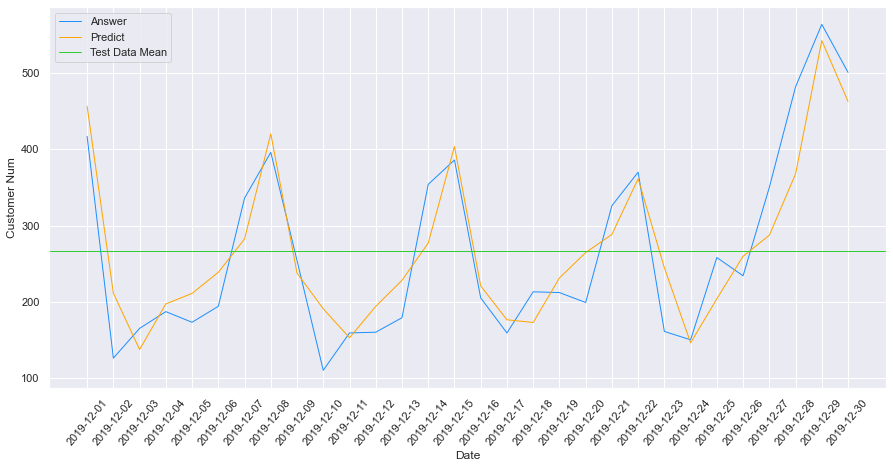

---------------------------------------------------------------------------------------
決定係数：0.8363418618593432
-
MSE(平均二乗誤差)　:  2370.1189776380766
-
RMSE(平均二乗平方根誤差)　:  48.683867734990784
---------------------------------------------------------------------------------------


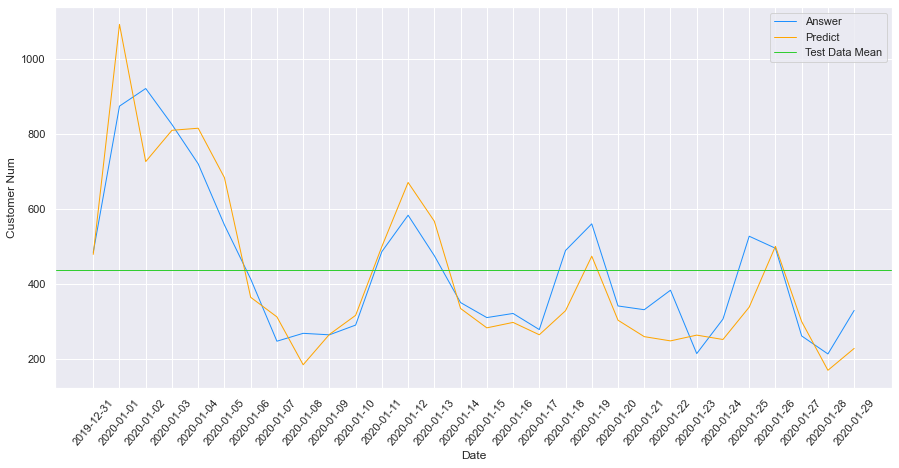

---------------------------------------------------------------------------------------
決定係数：0.7649051818615449
-
MSE(平均二乗誤差)　:  8535.573195247336
-
RMSE(平均二乗平方根誤差)　:  92.38816588312237
---------------------------------------------------------------------------------------


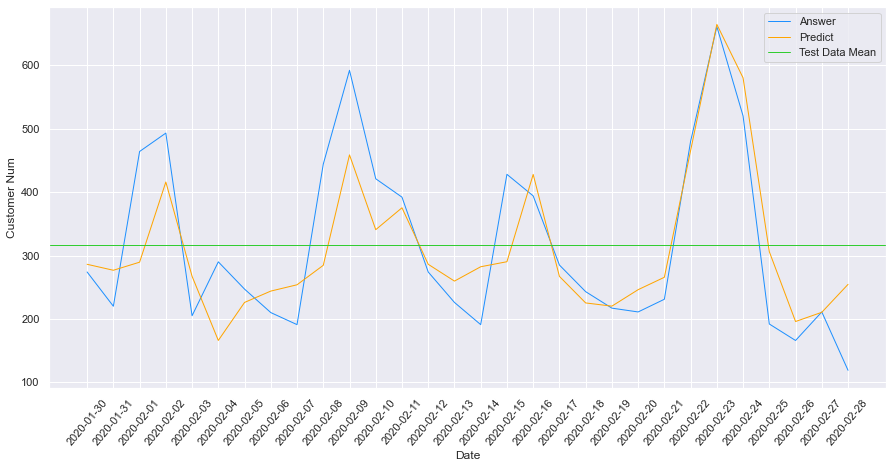

---------------------------------------------------------------------------------------
決定係数：0.6793818993480977
-
MSE(平均二乗誤差)　:  6111.9770519912845
-
RMSE(平均二乗平方根誤差)　:  78.17913437734703
---------------------------------------------------------------------------------------


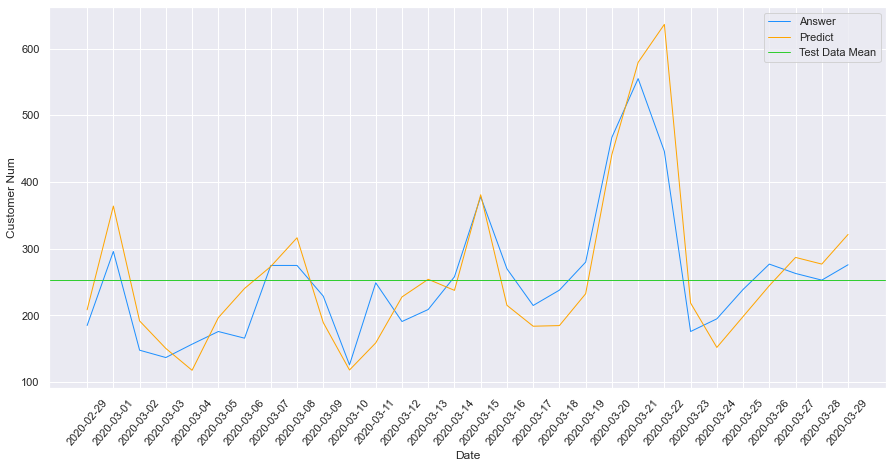

---------------------------------------------------------------------------------------
決定係数：0.6928411280950624
-
MSE(平均二乗誤差)　:  2871.00885638092
-
RMSE(平均二乗平方根誤差)　:  53.58179594210071
---------------------------------------------------------------------------------------


In [ ]:
for i in range(len(predict_list)):
# for i in range(2):
    
    plt.figure(figsize=(15, 7))
    plt.plot(test_y_list[i], color='dodgerblue', linewidth=1, label="Answer")
    plt.plot(predict_list[i], color='orange', linewidth=1, label="Predict")
    plt.axhline(y=float(test_y_list[i].mean()), color='limegreen', linewidth=1, label="Test Data Mean")
#     plt.plot(float(test_y_list[i].mean()), color='lime', linewidth=1, label="Test Data Mean")
    plt.legend(loc = 'best')
    plt.xticks(rotation=50)
    plt.xlabel("Date")
    plt.ylabel("Customer Num")
    plt.show()
    plt.close()

    print("---------------------------------------------------------------------------------------")
    print("決定係数：{}".format(r2_list[i]))
    print("-")
    print("MSE(平均二乗誤差)　:  {}".format(mse_list[i]))
    print("-")
    print("RMSE(平均二乗平方根誤差)　:  {}".format(rmse_list[i]))
    print("---------------------------------------------------------------------------------------")

In [ ]:
# 予測結果
# f = open('./output/after/predict_list.txt', 'wb')
# pickle.dump(predict_list, f)

# 二乗平均平方根誤差
rmse_plot = pd.DataFrame(rmse_list)
rmse_plot.index = date_list
rmse_plot.columns = ['RMSE'] 
# rmse_plot.to_pickle('./output/after/rmse_list.pkl')

# 決定係数
r2_plot = pd.DataFrame(r2_list)
r2_plot.index = date_list
r2_plot.columns = ['R^2']
# r2_plot.to_pickle('./output/after/r2_list.pkl')